In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import math
from __future__ import print_function
import cv2 as cv
import argparse

In [6]:
import h5py

h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')

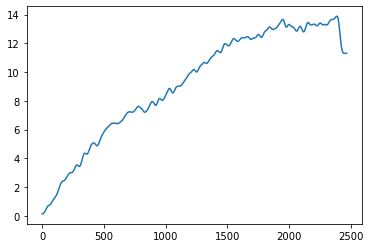

In [4]:
plt.plot(list(f['climbs/0/height_profile']))

In [7]:
height_profile = f['climbs/0/height_profile']

def buildmebarchart(i=int):
    p = plt.plot(height_profile[:(i*10)]) #note it only returns the dataset, up to the point i
    plt.xlabel('Steps')
    plt.ylabel('Height')

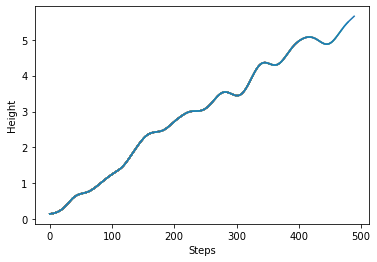

In [8]:
""" MAKE ANIMATED GRAPH """
height_profile = f['climbs/0/height_profile']
fig = plt.figure()
animator = ani.FuncAnimation(fig, buildmebarchart, interval = 10, frames=50)
animator.save('anim_graph.mp4', savefig_kwargs={'transparent': True, 'facecolor': 'none'})
plt.show()

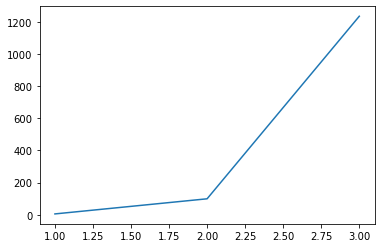

In [9]:
plt.clf()
plt.plot([1,2,3],[2,4,6])
plt.savefig('testplot.jpg')
plt.clf()
plt.plot([1,2,3],[5,99,1234])
plt.savefig('testplot.jpg')

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

graph = 'anim_graph.mp4'
cap_g = cv2.VideoCapture(graph)
backSub = cv2.createBackgroundSubtractorMOG2()
vid = 'test.mp4'
cap = cv2.VideoCapture(vid)

graph_width = int(cap_g.get(3))
graph_height = int(cap_g.get(4))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width,frame_height))

while True:
    gret, gframe = capture.read()
    
    if frame is None:
        break
    
    fgMask = backSub.apply(gframe)
    
    cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    
    out.write(fgMask)

    cv2.imshow('Frame', frame)
    cv2.imshow('FG Mask', fgMask)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# When everything done, release the video capture and video write objects
capture.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows()


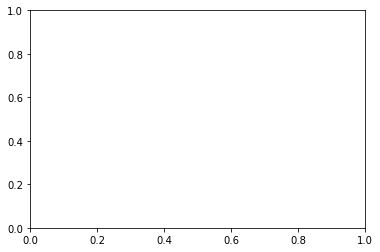

TypeError: Image data of dtype object cannot be converted to float

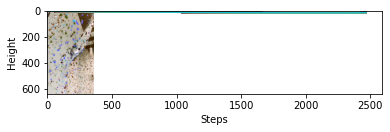

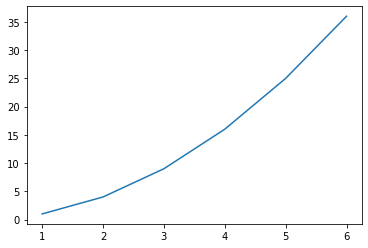

In [6]:
x = [1,2,3,4,5,6]
y = [1,4,9,16,25,36]
plt.plot(x,y)
plt.savefig('testplot.jpg')

TypeError: 'NoneType' object is not subscriptable

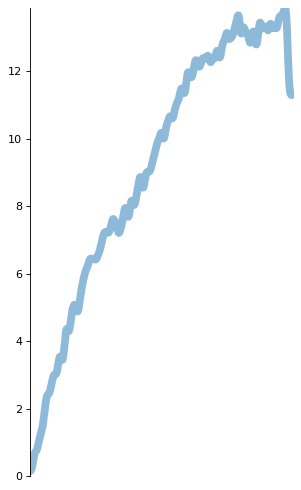

In [1]:
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')

filename = './test.mp4'
cap = cv2.VideoCapture(filename)
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer= cv2.VideoWriter('basicvideo.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, (width,height))
height_profile = f['climbs/0/height_profile']
max_height = max(height_profile)
len_height = len(height_profile)
i = 0

""" Set figure size, so it's not bigger than video """
figure(num=None, figsize=((width - 20)/80, (height - 20)/80), dpi=80)

while True:
    ret,frame= cap.read()
    plt.clf()
    plt.plot(height_profile[:(i*10)], linewidth=7.0, alpha=0.5)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    plt.savefig('plot.png', transparent=True)
    
    overlay = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
    l_img = frame
    s_img = overlay    
    
    y_offset = x_offset = 5
    y1, y2 = y_offset, y_offset + s_img.shape[0]
    x1, x2 = x_offset, x_offset + s_img.shape[1]
    alpha_s = s_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        l_img[y1:y2, x1:x2, c] = (alpha_s * s_img[:, :, c] +
                                  alpha_l * l_img[y1:y2, x1:x2, c])
    
    writer.write(l_img)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

    i += 1

cv2.imshow('frame', frame)

cap.release()
writer.release()
cv2.destroyAllWindows()


In [31]:
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
f.keys()
list(f['/climbs/all'])[0][1] - list(f['/climbs/all'])[0][0]


240.79999995231628

In [13]:
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

# playback speed = out_fps/30 * speed_up   
# speed_up is positive int, e.g. 2 means skip every 2nd frame, 3 skip every 3rd frame
def overlayGraph(videofile, outfile, graphFunc, out_fps, speed_up):
    cap = cv2.VideoCapture(videofile)
    width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer= cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'MP4V'), out_fps, (width,height))    

    """ Set figure size, so it's not bigger than video """
    figure(num=None, figsize=((width - 20)/80, (height - 20)/80), dpi=80)
    i = 0 # count which frame we are on
    while True:
        if not (i % speed_up == 0):
            cap.read()
            i+=1
            continue
        ret,frame = cap.read()

        if not ret:
            break
        
        time = i / 30;
        new_frame = graphFunc(time, frame)

        writer.write(new_frame)
        cv2.imshow('frame', new_frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break
            
        i+=1

    cap.release()
    writer.release()
    cv2.destroyAllWindows()


In [14]:
h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']
max_height = max(height_profile)
len_height = len(height_profile)
def graphFunc(time, frame):
    if time > len_height:
        return True
    plt.clf()
    # for '/climbs/0/height_profile' we are sampling at 10Hz, i.e. every 0.1s
    ind = min(math.floor(time/0.1), len_height) # stay in bounds
    plt.plot(height_profile[:math.floor(time/0.1)], linewidth=7.0, alpha=0.5)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    
    plt.savefig('plot.png', transparent=True)

    # imread_unchange reads plot.png with 4 channels, i.e. including alpha channel which
    # describes the transparancy
    overlay = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
    new_frame = frame

    y_offset = x_offset = 5
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o

    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])
    
    return new_frame

In [15]:
overlayGraph('./data/overhang/Overhang.mp4', 'graphvid.mp4', graphFunc)

TypeError: overlayGraph() missing 2 required positional arguments: 'out_fps' and 'speed_up'

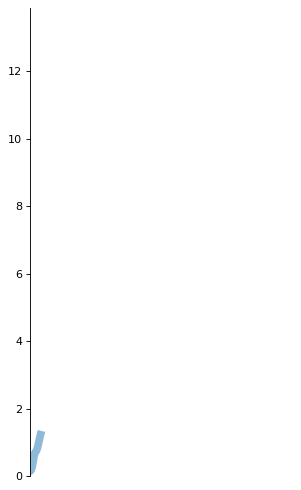

In [16]:
overlayGraph('./test.mp4', 'graphvid.mp4', graphFunc, 45, 2)